# Extract Data

## Setup

In [1]:
from os.path import abspath, join
from os import listdir

import glob
import geopandas as gpd

import scipy.ndimage as ndimage
import rasterio, rasterio.mask
from rasterio.plot import reshape_as_raster, reshape_as_image
from skimage.color import rgb2gray
import mahotas

from shapely.geometry import mapping

import math, statistics

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
plt.style.use('seaborn-deep')

In [2]:
path = {'root': abspath("/mnt/hgfs/Storage/Documents/Image Classification")}

path['shapefiles'] = join(path['root'], "Shapefiles")
path['images'] = join(path['root'], "Images")
path['stacked'] = join(path['root'], "Stacked")
path['hist'] = join(path['root'], "Histograms")
path['data'] = join(path['root'], "Data")

In [3]:
# All contents in directory
listdir(path['shapefiles'])

# Only *.shp files in directory
shps = glob.glob(join(path['shapefiles'], "*.shp"))
shapefile = shps[2]
shapefile

'/mnt/hgfs/Storage/Documents/Image Classification/Shapefiles/merged_classes.shp'

In [4]:
flatten = lambda ll: [i for l in ll for i in l]

## Choose Shapes

In [5]:
shapeframe = gpd.read_file(shapefile)

shapeframe['area'] = list(map((lambda g: g.area), shapeframe['geometry']))

shapeframe

ID CODE_TFV                                  TFV  \
0      FORESTIE0000000004523655      LA4                                Lande   
1      FORESTIE0000000004500002   FF1-00  Fort ferme de feuillus purs en lots   
2      FORESTIE0000000004523656      LA4                                Lande   
3      FORESTIE0000000004500004   FF1-00  Fort ferme de feuillus purs en lots   
4      FORESTIE0000000004523658      LA4                                Lande   
...                         ...      ...                                  ...   
17913  FORESTIE0000000008908466       FP                           Peupleraie   
17914  FORESTIE0000000008908472       FP                           Peupleraie   
17915  FORESTIE0000000008908473       FP                           Peupleraie   
17916  FORESTIE0000000008908474       FP                           Peupleraie   
17917  FORESTIE0000000008908480      FO1        Fort ouverte de feuillus purs   

                     TFV_G11   ESSENCE    SURF code_tfv_2     Nomenc_CES  \
0                      Lande        NC  1.2745        LA4  4.0.0.0.0.0.0   
1        Fort ferme feuillus  Feuillus  1.6074     FF1-00  1.1.2.5.0.0.0   
2                      Lande        NC  0.7006        LA4  4.0.0.0.0.0.0   
3        Fort ferme feuillus  Feuillus  1.9273     FF1-00  1.1.2.5.0.0.0   
4                      Lande        NC  2.0225        LA4  4.0.0.0.0.0.0   
...                      ...       ...     ...        ...            ...   
17913             Peupleraie  Peuplier  2.1733         FP  1.1.1.4.1.1.1   
17914             Peupleraie  Peuplier  5.6450         FP  1.1.1.4.1.1.1   
17915             Peupleraie  Peuplier  1.4742         FP  1.1.1.4.1.1.1   
17916             Peupleraie  Peuplier  6.6343         FP  1.1.1.4.1.1.1   
17917  Fort ouverte feuillus  Feuillus  0.8506        FO1  1.1.3.0.0.0.0   

                      Nom_nomenc CODE_ess  \
0                 Lande ligneuse  4000000   
1      Futaie de feuillus divers  1125000   
2                 Lande ligneuse  4000000   
3      Futaie de feuillus divers  1125000   
4                 Lande ligneuse  4000000   
...                          ...      ...   
17913                 Peupleraie  1114111   
17914                 Peupleraie  1114111   
17915                 Peupleraie  1114111   
17916                 Peupleraie  1114111   
17917  Foret ouverte de feuillus  1130000   

                                                geometry          area  
0      POLYGON ((480244.862 5290567.493, 480257.848 5...  12751.982793  
1      POLYGON ((432725.383 5349519.338, 432726.763 5...  16086.243487  
2      POLYGON ((482147.573 5290528.974, 482109.455 5...   7009.353826  
3      POLYGON ((426915.196 5341760.895, 426921.989 5...  19289.488170  
4      POLYGON ((480373.923 5297776.336, 480361.644 5...  20235.731332  
...                                                  ...           ...  
17913  POLYGON ((506056.710 5338779.744, 506055.696 5...  21748.473077  
17914  POLYGON ((507153.119 5333182.746, 507152.706 5...  56479.406102  
17915  POLYGON ((504813.101 5334470.343, 504818.449 5...  14752.552619  
17916  POLYGON ((505030.026 5333209.073, 505031.707 5...  66380.115885  
17917  POLYGON ((505747.624 5340136.475, 505758.926 5...   8514.149040  

[17918 rows x 12 columns]

In [6]:
def get_ess_shapes(ess, gdf):
    return gdf[gdf['CODE_ess']==ess]

In [7]:
def get_ess_shapes_with_area(ess, gdf, ascending, minimum=200):
    essdf = get_ess_shapes(ess, gdf)
    
    if essdf.shape[0] < minimum:
        return None
    
    return essdf.sort_values('area', ascending=ascending)

In [8]:
def get_shapes_by_area(ess_shapes, area=20.0, minimum=2): # Area (Km^2)
    rows = 1
    area_ess_shapes = ess_shapes.head(rows)
    
    while minimum > rows or sum(area_ess_shapes['area'])/10**6 < area:
        rows += 1
        area_ess_shapes = ess_shapes.head(rows)
        if rows == ess_shapes.shape[0]:
            break
    
    return area_ess_shapes

In [9]:
def get_chosen_shapes_indices(code):
    codeshapes = get_ess_shapes_with_area(code, shapeframe, ascending=True)
    if codeshapes is not None:
        return get_shapes_by_area(codeshapes).index.values.tolist()
    return []

In [10]:
chosenindices = flatten([get_chosen_shapes_indices(code) for code in shapeframe.CODE_ess.unique()])

In [11]:
chosenshapes = shapeframe.iloc[chosenindices]

In [12]:
def get_ess_area(code, chosenshapes, totalshapes):
    
    total = len(get_ess_shapes(code, totalshapes))
    
    codechosen = get_ess_shapes(code, chosenshapes)
    chosen = len(codechosen)
    area = sum(get_ess_shapes(code, chosenshapes).area)/10**6
    
    return [code, total, chosen, area]
    
def get_ess_shapeareas(chosenshapes, totalshapes):    
    ess_shapelengths = [get_ess_area(code, chosenshapes, totalshapes) 
                        for code in chosenshapes.CODE_ess.unique()]
    
    return pd.DataFrame(ess_shapelengths, columns=["ESS Label", "Total Shapes", "Chosen Shapes", "Chosen Area (km^2)"])

In [13]:
get_ess_shapeareas(chosenshapes, shapeframe)

ESS Label  Total Shapes  Chosen Shapes  Chosen Area (km^2)
0   4000000           916            916           19.562118
1   1125000          9654           2818           20.000161
2   1381100          1768            917           20.031880
3   1111100          1090            535           20.020290
4   1211000          1507            731           20.028464
5   1114111           617            617           18.016251
6   1116000           311            311           19.531851
7   1130000           683            683           19.349031
8   2000000           743            700           20.013479
9   1117000           267            267           10.883683

## Extract Features

In [14]:
bandOrder = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

In [15]:
# 14 Feature as described here 
## http://murphylab.web.cmu.edu/publications/boland/boland_node26.html

# As provided by mahotas.features.haralick 
## https://mahotas.readthedocs.io/en/latest/api.html?#mahotas.features.haralick

glcmFeatures = ['GLCM_' + str(f) for f in range(13)]

In [16]:
for feat in bandOrder+glcmFeatures:
    chosenshapes.insert(len(chosenshapes.columns), feat, None)

In [17]:
chosenshapes.columns

Index(['ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'SURF', 'code_tfv_2',
       'Nomenc_CES', 'Nom_nomenc', 'CODE_ess', 'geometry', 'area', 'B2', 'B3',
       'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'GLCM_0', 'GLCM_1',
       'GLCM_2', 'GLCM_3', 'GLCM_4', 'GLCM_5', 'GLCM_6', 'GLCM_7', 'GLCM_8',
       'GLCM_9', 'GLCM_10', 'GLCM_11', 'GLCM_12'],
      dtype='object')

In [18]:
# Process mask before feature extraction
def process_mask(out_image):
    
    # Erode Masked Image by 1
    for b, band in enumerate(out_image):
        erosion = ndimage.binary_erosion(band)
        out_image[b][erosion == False] = 0

    # Crop Image by 1
    out_image = out_image[:, 1:-1, 1:-1]
    
    return out_image

In [19]:
# Erode Mask and Return Mask Pixel Values
def get_mask_pixels(out_image):

    # Remove Nomask Pixels
    out_image = [band[band != -1] for band in out_image]

    return out_image

In [21]:
# Known from reviewing bandstats in the future
## bandstats['max'][i]
tempstats = [589, 832, 1011]

In [22]:
# Compute the Haralick GLCM Texture Feature Vector
def get_mask_glcm(out_image):
    
    # Normalize Band Max to 255
    out_image = np.array([band / (tempstats[i]/255.0) for i, band in enumerate(out_image)])
    
    # Convert from (Band, Row, Col) to (Row, Col, Band)
    out_image = reshape_as_image(out_image)
    
    # Convert from BGR to RGB
    out_image = out_image[:,:,::-1]
    
    # Grayscale from RGB
    gray_image = rgb2gray(out_image)
    
    # Typecast from float to int
    gray_image = [np.int_(np.round(gray_image[i])) for i, band in enumerate(gray_image)]
    gray_image = np.array(gray_image)

    return mahotas.features.haralick(gray_image).mean(axis=0)    

In [23]:
# Feature are hardcoded to be stored in chosenshapes
def extract_band_pixels(stack, shapes):
    
    droprows = []
    
    with rasterio.open(stack) as stk:
        for num, row in shapes.iterrows():
            
            out_image, out_transform = rasterio.mask.mask(
                stk, [mapping(row['geometry'])],
                crop=True,
                all_touched=True,
                nodata=-1)
            
            # Both Height and Width must be larger than 2 pixels, else all mask is eroded
            # With this in mind, there must be left more than 1 pixel for GLCM to calculate correlation
            # i.e: 2+1 
            if min(out_image[0].shape) > 3:
            
                # Process Image
                out_image = process_mask(out_image)
            
                # Extract Pixels
                pixels = get_mask_pixels(out_image)
                
                # Store Pixels
                for i, band in enumerate(bandOrder):
                    chosenshapes.at[num, band] = pixels[i]
                
                # Extract GLCM Features, with first 3 bands (BGR) only
                glcm = get_mask_glcm(out_image[:3])
                
                # Store Pixels
                for i, feat in enumerate(glcmFeatures):
                    chosenshapes.at[num, feat] = glcm[i]
            
            else:
                droprows.append(num)
                                      
    return droprows

In [24]:
dataset = listdir(path['images'])[0]
stack = join(path['stacked'], '_Stacks', 'BStack_' + dataset + '.tif')

droprows = extract_band_pixels(stack, chosenshapes)

In [25]:
# Drop Shapes with too small pixels
chosenshapes = chosenshapes.drop(droprows, errors='ignore')
get_ess_shapeareas(chosenshapes, shapeframe)

ESS Label  Total Shapes  Chosen Shapes  Chosen Area (km^2)
0   4000000           916            910           19.552702
1   1125000          9654           2796           19.984810
2   1381100          1768            916           20.031331
3   1111100          1090            529           20.017725
4   1211000          1507            730           20.028364
5   1114111           617            617           18.016251
6   1116000           311            311           19.531851
7   1130000           683            681           19.348095
8   2000000           743            697           20.010945
9   1117000           267            266           10.881122

## Visualise Mask from Each Class

In [ ]:
def save_mask(stack, shapes, maskpath):
    shapes
    with rasterio.open(stack) as stk:
        for num, row in shapes.iterrows():
            band_values = {b: None for b in bandOrder}

            out_image, out_transform = rasterio.mask.mask(
                stk, [mapping(row['geometry'])],
                crop=True,
                all_touched=True,
                nodata=-1)
            
            pixels = get_mask_pixels(out_image)
            if pixels is None:
                continue
                
            # Transform window to place crop correctly
            win = rasterio.windows.Window.from_slices(slice(1, -1),
                                                      slice(1, -1),
                                                      height=100,
                                                      width=100)
            out_transform = rasterio.windows.transform(win, out_transform)

            # Update Meta for export
            out_meta = stk.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })
            
            # Setup file path for export
            file_path = join(maskpath, row['ess'] + '.tif')

            # Export Masked Image
            with rasterio.open(file_path, "w", **out_meta) as dest:
                dest.write(out_image)

In [ ]:
classmasks = gpd.GeoDataFrame([[get_ess_shapes_with_area(ess, chosenshapes, ascending=False).head(1)['geometry'].index.values[0], 
                                ess, 
                                get_ess_shapes_with_area(ess, chosenshapes, ascending=False).head(1)['geometry'].values[0]] 
 for ess in chosenshapes.CODE_ess.unique()], columns=['ID', 'ess', 'geometry'])

In [ ]:
classmasks

In [ ]:
save_mask(stack, classmasks, path['masks'])

## Histogram Functions

In [26]:
# Collect All Pixels for each band
def all_band_stats(pixels):
    pixels = np.sort(pixels)
    nall = len(pixels)
    minall = min(pixels)
    maxall = max(pixels)
    
    return pixels, nall, minall, maxall

In [27]:
# Percentile Stats
def percentile_stats(pixels, n, percentile=95.0):
    pixels = pixels[:math.ceil(n * percentile/100.0)]
    n = len(pixels)
    minpix = min(pixels)
    maxpix = max(pixels)
    
    return pixels, n, minpix, maxpix

### Use Freedman-Diaconis for Bins

In [28]:
# Calculate Interquartile Range
f_irq = lambda ns: np.subtract(*np.percentile(ns, [75, 25]))

# Calculate Freedman-Diaconis Rule Bin Width Estimator
f_fd = lambda n, ns: int(math.ceil(2.0 * f_irq(ns) * (n ** (-1/3))))

In [29]:
# Bin Stats, including Freedman-Diaconis
def bin_stats(pixels, n):
    fd = f_fd(n, pixels)
    #bins = max(12, fd)
    bins = fd
    
    return fd, bins

### Calculate Histogram and Edges 

In [30]:
def hist_stats(ns, bins):
    hist, edges = np.histogram(ns, bins=bins, density=True)
    prob_hist = (lambda b: b * (edges[1]-edges[0]))(hist)
    
    return prob_hist, edges

### Compute Band Stats

In [31]:
def get_band_stats(band, bandvalues):
    # All Pixel Stats
    pixels, nall, _, maxall = all_band_stats(bandvalues)
    
    # 95.0 Percentile Stats
    pixels, n, minpix, maxpix = percentile_stats(pixels, nall)
    
    # Bin Stats
    fd, bins = bin_stats(pixels, n)
    
    # Histogram Stats
    hist, edges = hist_stats(pixels, bins)
    
    return [band, nall, maxall, n, minpix, maxpix, fd, hist, edges, bins, hist, edges, pixels]

## Compute Band Histograms

In [32]:
bandcolumns=['band', 'n_all', 'max_all', 'n', 'min', 'max', 'fd', 'hist_fd', 'edges_fd', 'bins', 'hist', 'edges', 'pixels']

bandstats = [get_band_stats(band, flatten(chosenshapes[band].values)) for band in bandOrder]

bandstats = pd.DataFrame(bandstats, columns=bandcolumns)
bandstats

band    n_all  max_all        n  min   max  fd  \
0   B2  2135133     6701  2028377    0   589   2   
1   B3  2135106     7217  2028351    0   832   3   
2   B4  2135218     7591  2028458    0  1011   4   
3   B5  2135094     5764  2028340    0  1364   6   
4   B6  2135094     6207  2028340    0  2644   7   
5   B7  2135094     6460  2028340    0  3299  10   
6   B8  2135113     7202  2028358    0  3633  12   
7  B8A  2135097     6711  2028343    0  3745  11   
8  B11  2135106     6678  2028351    0  2755  11   
9  B12  2135102     6091  2028347    0  1693   8   

                                             hist_fd  \
0           [0.7229982394791501, 0.2770017605208499]   
1  [0.06551676706842159, 0.7567141978878409, 0.17...   
2  [0.38009907032829865, 0.42670245082718006, 0.1...   
3  [0.0004077225711665697, 0.01891842590492718, 0...   
4  [0.0006946567143575535, 0.001545598864095763, ...   
5  [0.0005270319571669444, 0.0006571876509855348,...   
6  [0.0011358941567514214, 0.001231045012764019, ...   
7  [0.0005965460476852288, 0.0005635141590943939,...   
8  [0.0006024598306703328, 0.0013912779395676587,...   
9  [0.001486925067555009, 0.056119589005234304, 0...   

                                            edges_fd  bins  \
0                                [0.0, 294.5, 589.0]     2   
1  [0.0, 277.3333333333333, 554.6666666666666, 83...     3   
2               [0.0, 252.75, 505.5, 758.25, 1011.0]     4   
3  [0.0, 227.33333333333334, 454.6666666666667, 6...     6   
4  [0.0, 377.7142857142857, 755.4285714285714, 11...     7   
5  [0.0, 329.9, 659.8, 989.6999999999999, 1319.6,...    10   
6  [0.0, 302.75, 605.5, 908.25, 1211.0, 1513.75, ...    12   
7  [0.0, 340.45454545454544, 680.9090909090909, 1...    11   
8  [0.0, 250.45454545454547, 500.90909090909093, ...    11   
9  [0.0, 211.625, 423.25, 634.875, 846.5, 1058.12...     8   

                                                hist  \
0           [0.7229982394791501, 0.2770017605208499]   
1  [0.06551676706842159, 0.7567141978878409, 0.17...   
2  [0.38009907032829865, 0.42670245082718006, 0.1...   
3  [0.0004077225711665697, 0.01891842590492718, 0...   
4  [0.0006946567143575535, 0.001545598864095763, ...   
5  [0.0005270319571669444, 0.0006571876509855348,...   
6  [0.0011358941567514214, 0.001231045012764019, ...   
7  [0.0005965460476852288, 0.0005635141590943939,...   
8  [0.0006024598306703328, 0.0013912779395676587,...   
9  [0.001486925067555009, 0.056119589005234304, 0...   

                                               edges  \
0                                [0.0, 294.5, 589.0]   
1  [0.0, 277.3333333333333, 554.6666666666666, 83...   
2               [0.0, 252.75, 505.5, 758.25, 1011.0]   
3  [0.0, 227.33333333333334, 454.6666666666667, 6...   
4  [0.0, 377.7142857142857, 755.4285714285714, 11...   
5  [0.0, 329.9, 659.8, 989.6999999999999, 1319.6,...   
6  [0.0, 302.75, 605.5, 908.25, 1211.0, 1513.75, ...   
7  [0.0, 340.45454545454544, 680.9090909090909, 1...   
8  [0.0, 250.45454545454547, 500.90909090909093, ...   
9  [0.0, 211.625, 423.25, 634.875, 846.5, 1058.12...   

                                              pixels  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 27, 32, 32, 33, 33, 36, 36, 38, 3...  
5  [0, 0, 0, 0, 12, 13, 13, 16, 17, 17, 18, 19, 2...  
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

## Clip all Pixel Masks

In [33]:
droprows = []

for num, row in chosenshapes.iterrows(): 
    for i, band in enumerate(bandOrder):
        truncated = row[band][row[band] <= bandstats.loc[i,'max']]
        if len(truncated) == 0:
            droprows.append(num)
            break
        else:
            chosenshapes.at[num, band] = truncated

In [34]:
# Drop Shapes with at least a band whose pixels are out of bounds
chosenshapes = chosenshapes.drop(droprows, errors='ignore')
get_ess_shapeareas(chosenshapes, shapeframe)

ESS Label  Total Shapes  Chosen Shapes  Chosen Area (km^2)
0   4000000           916            899           19.408114
1   1125000          9654           2777           19.866586
2   1381100          1768            915           20.024967
3   1111100          1090            529           20.017725
4   1211000          1507            730           20.028364
5   1114111           617            616           18.009555
6   1116000           311            311           19.531851
7   1130000           683            677           19.289198
8   2000000           743            694           19.975417
9   1117000           267            266           10.881122

## Compute ESS Histograms

In [35]:
essbandcolumns = ['ess', 'band', 'n', 'min', 'max', 'fd', 'hist_fd', 'edges_fd', 'bins', 'hist', 'edges', 'pixels']

In [36]:
def get_ess_band_stats(code, band, bandvalues):
    # All Pixel Stats
    pixels, n, minpix, maxpix = all_band_stats(bandvalues)
    
    # Bin Stats
    fd, bins = bin_stats(pixels, n)
    
    # Histogram Stats
    hist, edges = hist_stats(pixels, bins)
    
    return [code, band, n, minpix, maxpix, fd, hist, edges, bins, hist, edges, pixels]

In [37]:
def get_ess_hists(code):    
    codeshapes = get_ess_shapes(code, chosenshapes)
    hists = [get_ess_band_stats(code, band, flatten(codeshapes[band])) for band in bandOrder]
    return hists

In [38]:
def get_ess_stats():    
    ess_stats = flatten([get_ess_hists(code) for code in chosenshapes.CODE_ess.unique()])
    return pd.DataFrame(ess_stats, columns=essbandcolumns)

In [39]:
essstats = get_ess_stats()
essstats

ess band       n  min   max  fd  \
0   4000000   B2  201413   40   589   6   
1   4000000   B3  201607   87   832   7   
2   4000000   B4  195600    1  1011  12   
3   4000000   B5  197454  174  1364  11   
4   4000000   B6  214463   80  2644  16   
..      ...  ...     ...  ...   ...  ..   
95  1117000   B7  119962  258  3299  19   
96  1117000   B8  119750    0  3633  23   
97  1117000  B8A  119884  246  3745  20   
98  1117000  B11  120615  107  2755  14   
99  1117000  B12  120908   37  1693  10   

                                              hist_fd  \
0   [0.009825582261323747, 0.14774617328573628, 0....   
1   [0.004692297390467592, 0.038867698046198794, 0...   
2   [0.0015950920245398773, 0.022719836400817997, ...   
3   [0.0009116047281898568, 0.003757837268427077, ...   
4   [0.0009185733669677288, 0.0019117516774455267,...   
..                                                ...   
95  [7.50237575232157e-05, 0.00010836764975575598,...   
96  [0.00020876826722338206, 0.0002004175365344467...   
97  [6.673117346768543e-05, 9.175536351806746e-05,...   
98  [0.00015752601251917258, 0.0006218132073125232...   
99  [0.0006203063486287094, 0.006393290766533233, ...   

                                             edges_fd  bins  \
0    [40.0, 131.5, 223.0, 314.5, 406.0, 497.5, 589.0]     6   
1   [87.0, 193.42857142857144, 299.8571428571429, ...     7   
2   [1.0, 85.16666666666667, 169.33333333333334, 2...    12   
3   [174.0, 282.1818181818182, 390.3636363636364, ...    11   
4   [80.0, 240.25, 400.5, 560.75, 721.0, 881.25, 1...    16   
..                                                ...   ...   
95  [258.0, 418.0526315789474, 578.1052631578948, ...    19   
96  [0.0, 157.95652173913044, 315.9130434782609, 4...    23   
97  [246.0, 420.95, 595.9, 770.8499999999999, 945....    20   
98  [107.0, 296.1428571428571, 485.2857142857143, ...    14   
99  [37.0, 202.6, 368.2, 533.8, 699.4, 865.0, 1030...    10   

                                                 hist  \
0   [0.009825582261323747, 0.14774617328573628, 0....   
1   [0.004692297390467592, 0.038867698046198794, 0...   
2   [0.0015950920245398773, 0.022719836400817997, ...   
3   [0.0009116047281898568, 0.003757837268427077, ...   
4   [0.0009185733669677288, 0.0019117516774455267,...   
..                                                ...   
95  [7.50237575232157e-05, 0.00010836764975575598,...   
96  [0.00020876826722338206, 0.0002004175365344467...   
97  [6.673117346768543e-05, 9.175536351806746e-05,...   
98  [0.00015752601251917258, 0.0006218132073125232...   
99  [0.0006203063486287094, 0.006393290766533233, ...   

                                                edges  \
0    [40.0, 131.5, 223.0, 314.5, 406.0, 497.5, 589.0]   
1   [87.0, 193.42857142857144, 299.8571428571429, ...   
2   [1.0, 85.16666666666667, 169.33333333333334, 2...   
3   [174.0, 282.1818181818182, 390.3636363636364, ...   
4   [80.0, 240.25, 400.5, 560.75, 721.0, 881.25, 1...   
..                                                ...   
95  [258.0, 418.0526315789474, 578.1052631578948, ...   
96  [0.0, 157.95652173913044, 315.9130434782609, 4...   
97  [246.0, 420.95, 595.9, 770.8499999999999, 945....   
98  [107.0, 296.1428571428571, 485.2857142857143, ...   
99  [37.0, 202.6, 368.2, 533.8, 699.4, 865.0, 1030...   

                                               pixels  
0   [40, 49, 51, 54, 54, 55, 55, 55, 57, 59, 59, 5...  
1   [87, 89, 90, 91, 94, 96, 98, 99, 100, 100, 100...  
2   [1, 16, 16, 21, 24, 26, 27, 27, 27, 30, 31, 32...  
3   [174, 188, 198, 200, 202, 205, 206, 206, 206, ...  
4   [80, 83, 83, 84, 85, 86, 86, 86, 86, 89, 89, 9...  
..                                                ...  
95  [258, 292, 321, 336, 362, 381, 387, 391, 405, ...  
96  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
97  [246, 287, 288, 332, 335, 340, 404, 410, 433, ...  
98  [107, 128, 175, 176, 181, 184, 207, 260, 265, ...  
99  [37, 49, 66, 68, 74, 95, 95, 97, 100, 100, 107...  

[100 r

### Set Bandstats Bin based on ESS Bins by Band

In [40]:
def hist_range_stats(ns, bins, edgerange):
    hist, edges = np.histogram(ns, bins=bins, density=True, range=edgerange)
    prob_hist = (lambda b: b * (edges[1]-edges[0]))(hist)
    edgep = list(map(lambda e: int(e), edges[1:]))
    
    return prob_hist, edges, edgep

In [41]:
for i, band in enumerate(bandOrder):
    
    # Get max bin size, determined by each ess, for each band
    ess_max_bin = max(essstats[essstats['band']==band]['bins'])
    bandstats.at[i, 'bins'] = ess_max_bin
    edge_range = (bandstats.loc[i, 'min'], bandstats.loc[i, 'max'])
    
    # Set the max bin size for each band, in bandstats
    hist, edges, _ = hist_range_stats(bandstats.loc[i, 'pixels'], ess_max_bin, edge_range)
    bandstats.at[i, 'hist'] = hist
    bandstats.at[i, 'edges'] = edges
    
    # Set the max bin size for each band, in bandstats
    for ie in essstats[essstats['band']==band].index.values.tolist():
        hist, edges, _ = hist_range_stats(essstats.loc[ie, 'pixels'], ess_max_bin, edge_range)
        essstats.at[ie, 'hist'] = hist
        essstats.at[ie, 'edges'] = edges

## Display Histograms

### Band Histograms

In [43]:
outband = list(zip(bandstats['band'], bandstats['fd'], bandstats['hist_fd'], bandstats['edges_fd'], bandstats['bins'], bandstats['hist'], bandstats['edges'], bandstats['min'], bandstats['max']))
outband[0]

('B2',
 2,
 array([0.72299824, 0.27700176]),
 array([  0. , 294.5, 589. ]),
 6,
 array([0.00600086, 0.26105403, 0.45594335, 0.16536324, 0.07249589,
        0.03914262]),
 array([  0.        ,  98.16666667, 196.33333333, 294.5       ,
        392.66666667, 490.83333333, 589.        ]),
 0,
 589)

### Band Pixels with FD Optimized Bins

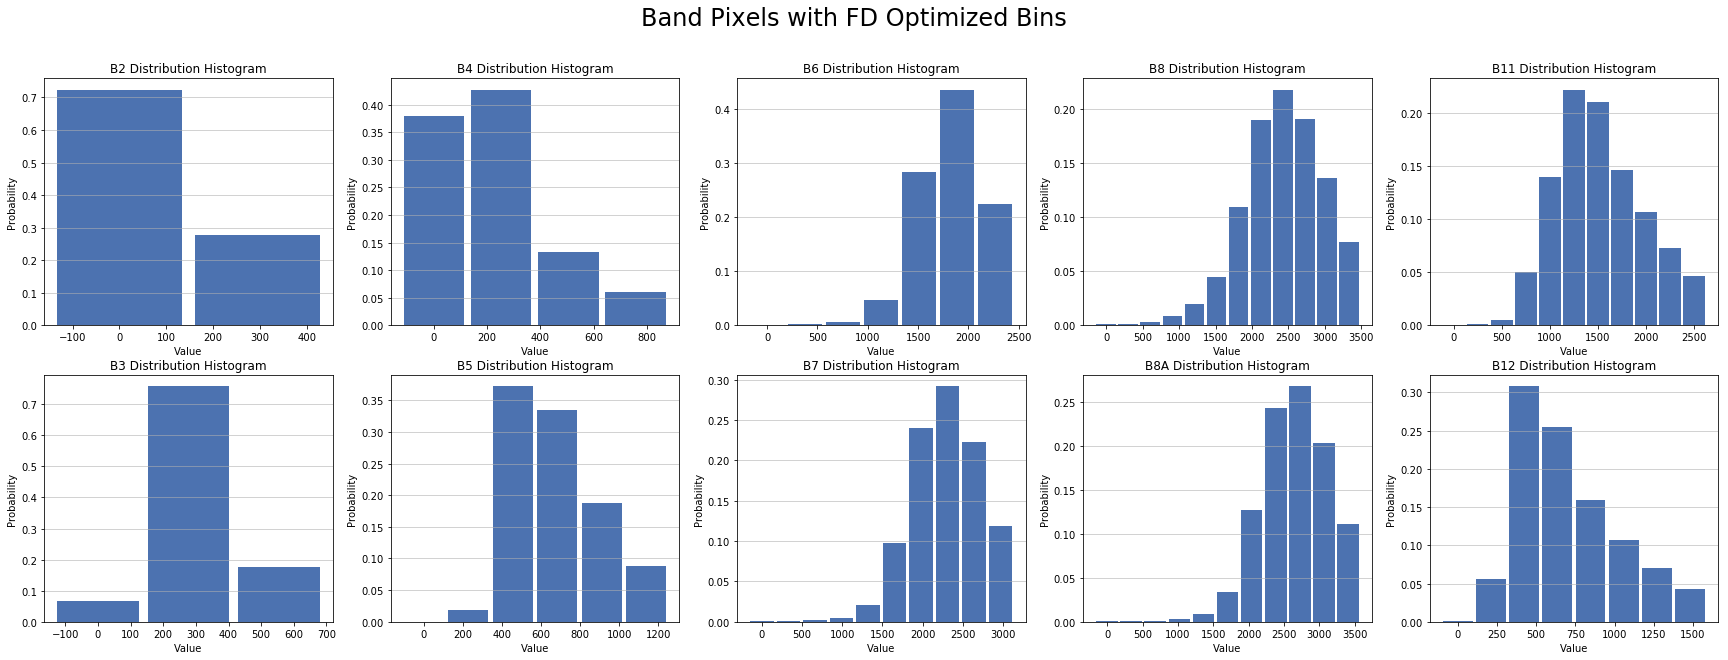

In [44]:
fig, axes = plt.subplots(2, 5, figsize=[30, 10])

for i, (band, hist, edges) in enumerate(list(zip(bandstats['band'], bandstats['hist_fd'], bandstats['edges_fd']))):  
    ax = axes[i%2][int(i/2)]
    ax.bar(edges[:-1], hist, width=0.9*(edges[1]-edges[0]), alpha=1)

    ax.set_title(band + ' Distribution Histogram')
    ax.set_xlabel('Value')
    ax.set_ylabel('Probability')
    ax.grid(axis='y', alpha=0.7)

fig.suptitle('Band Pixels with FD Optimized Bins', fontsize=24)
    
plt.savefig(join(path['hist'], 'merged_hist_fd.png'), bbox_inches='tight', dpi=256)
plt.show()

### Band Pixels with Global Bins

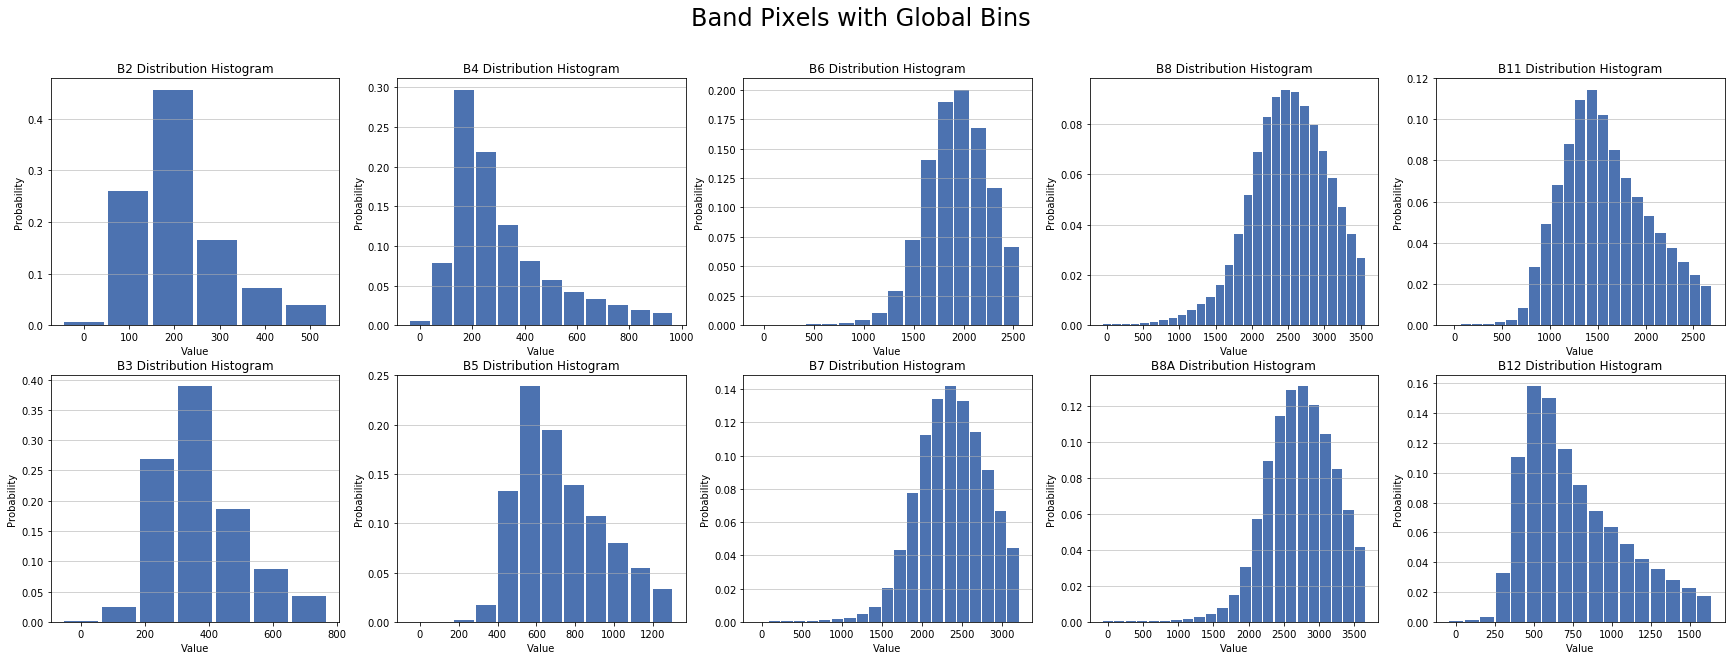

In [45]:
fig, axes = plt.subplots(2, 5, figsize=[30, 10])
for i, (band, _, _, _, bins, hist, edges, minb, maxb) in enumerate(outband):
    ax = axes[i%2][int(i/2)]
    ax.bar(edges[:-1], hist, width=0.9*(edges[1]-edges[0]), alpha=1)

    ax.set_title(band + ' Distribution Histogram')
    ax.set_xlabel('Value')
    ax.set_ylabel('Probability')
    ax.grid(axis='y', alpha=0.7)

fig.suptitle('Band Pixels with Global Bins', fontsize=24)

plt.savefig(join(path['hist'], 'merged_hist.png'), bbox_inches='tight', dpi=256)
plt.show()

### ESS Band Pixels with FD Optimized Bins

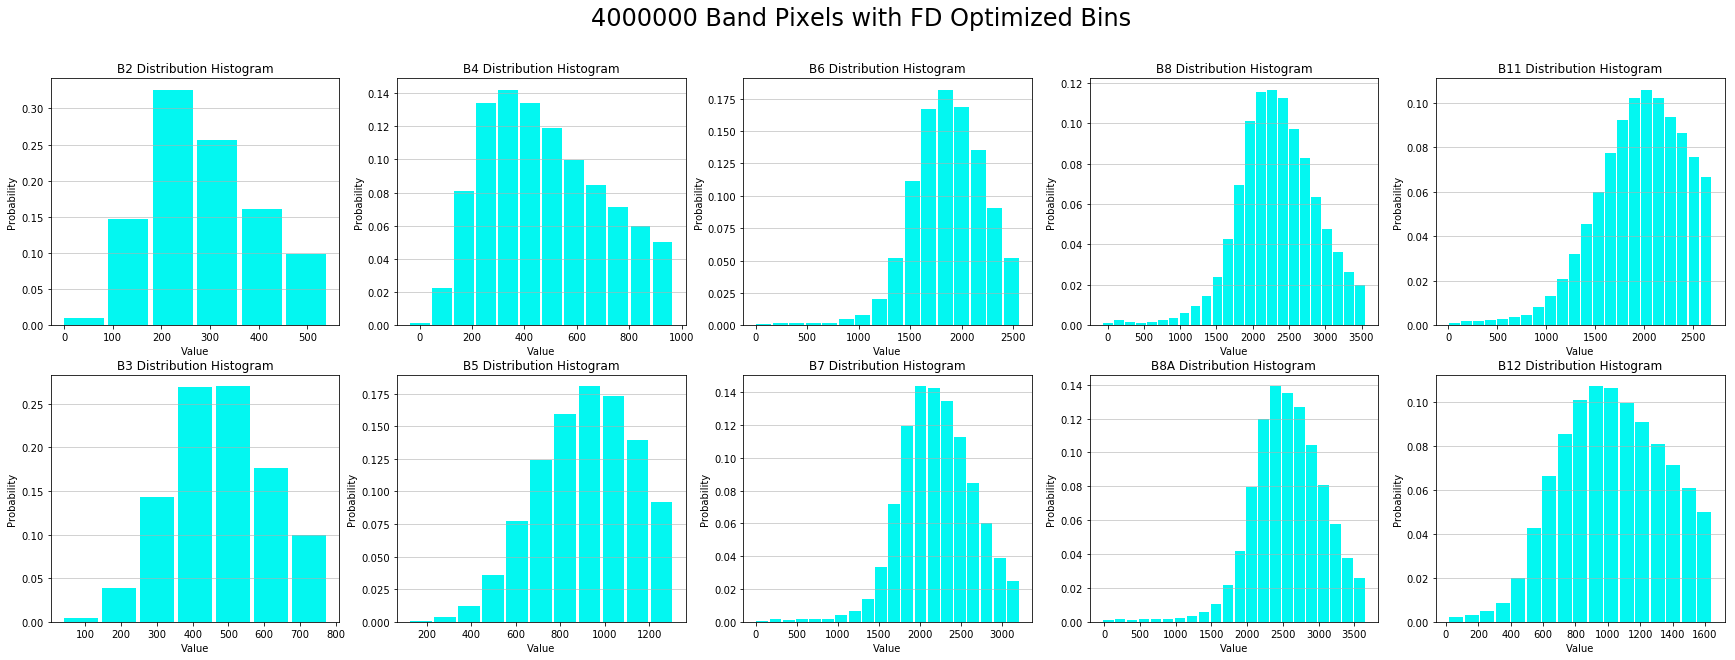

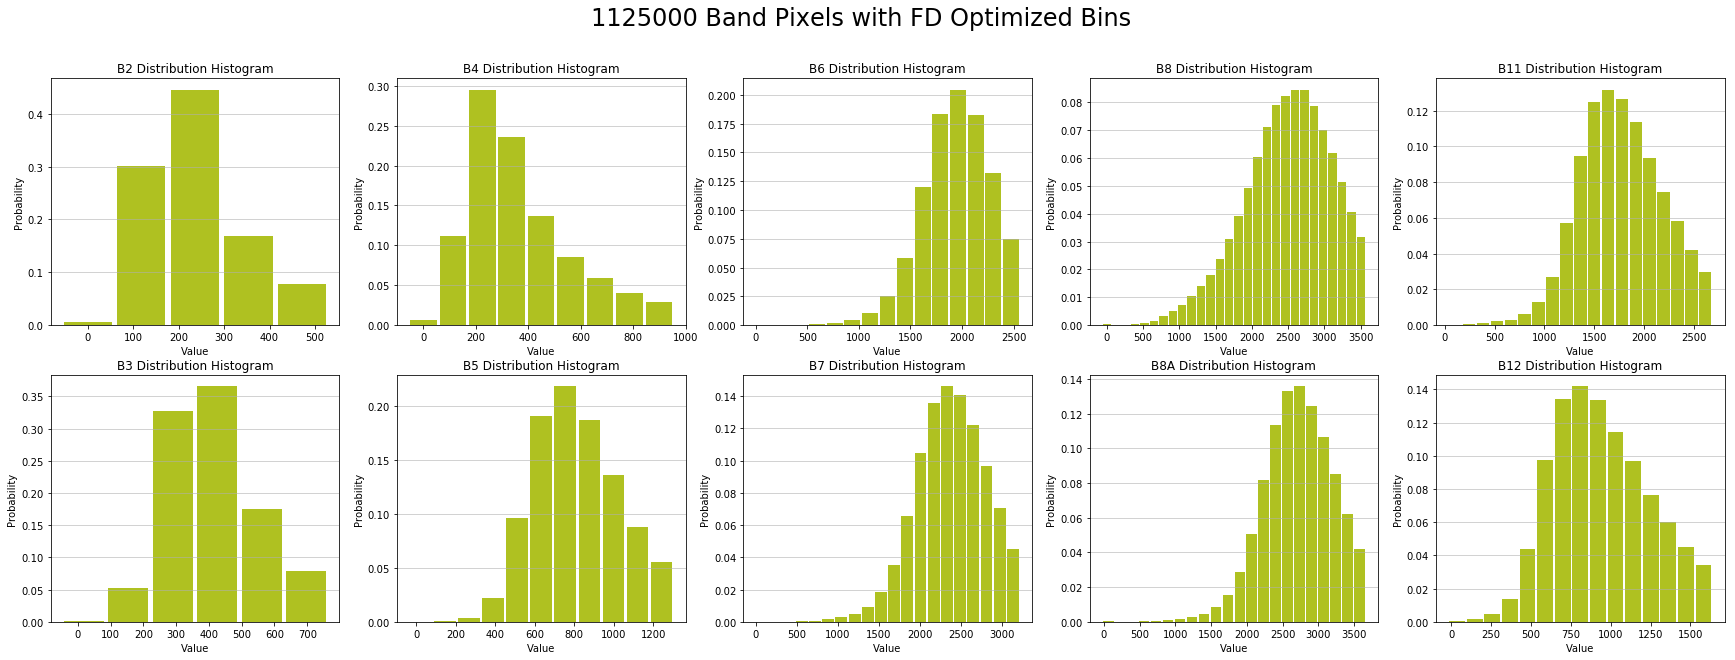

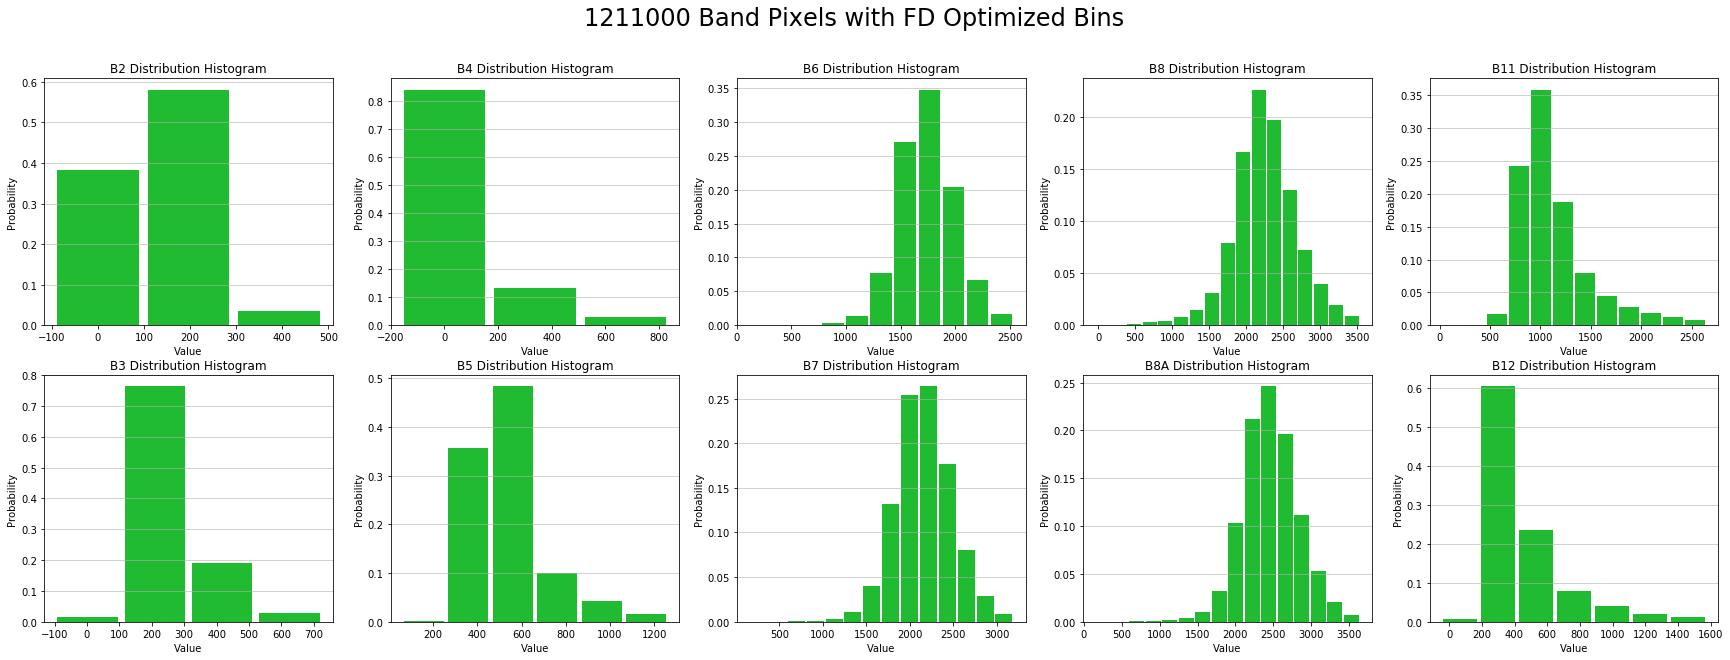

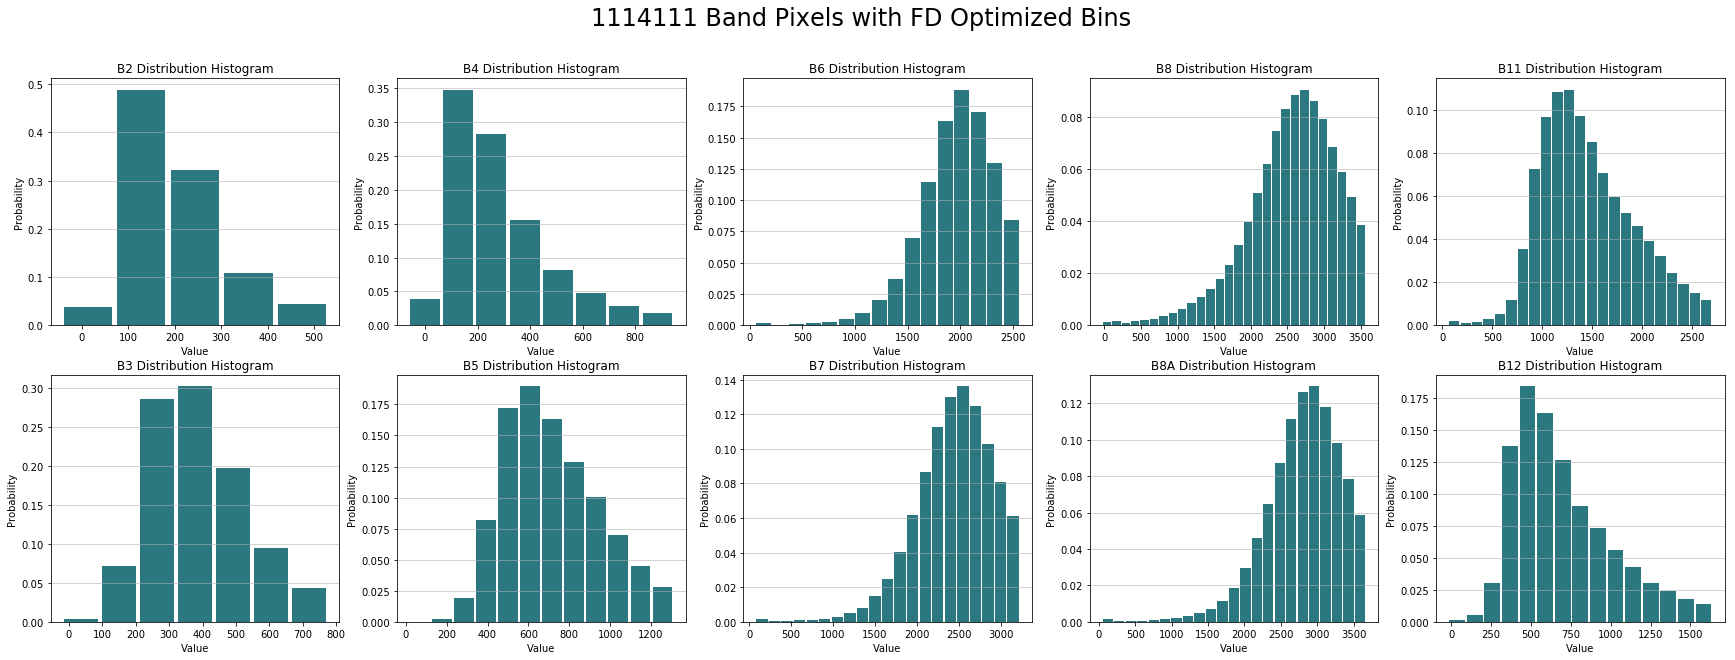

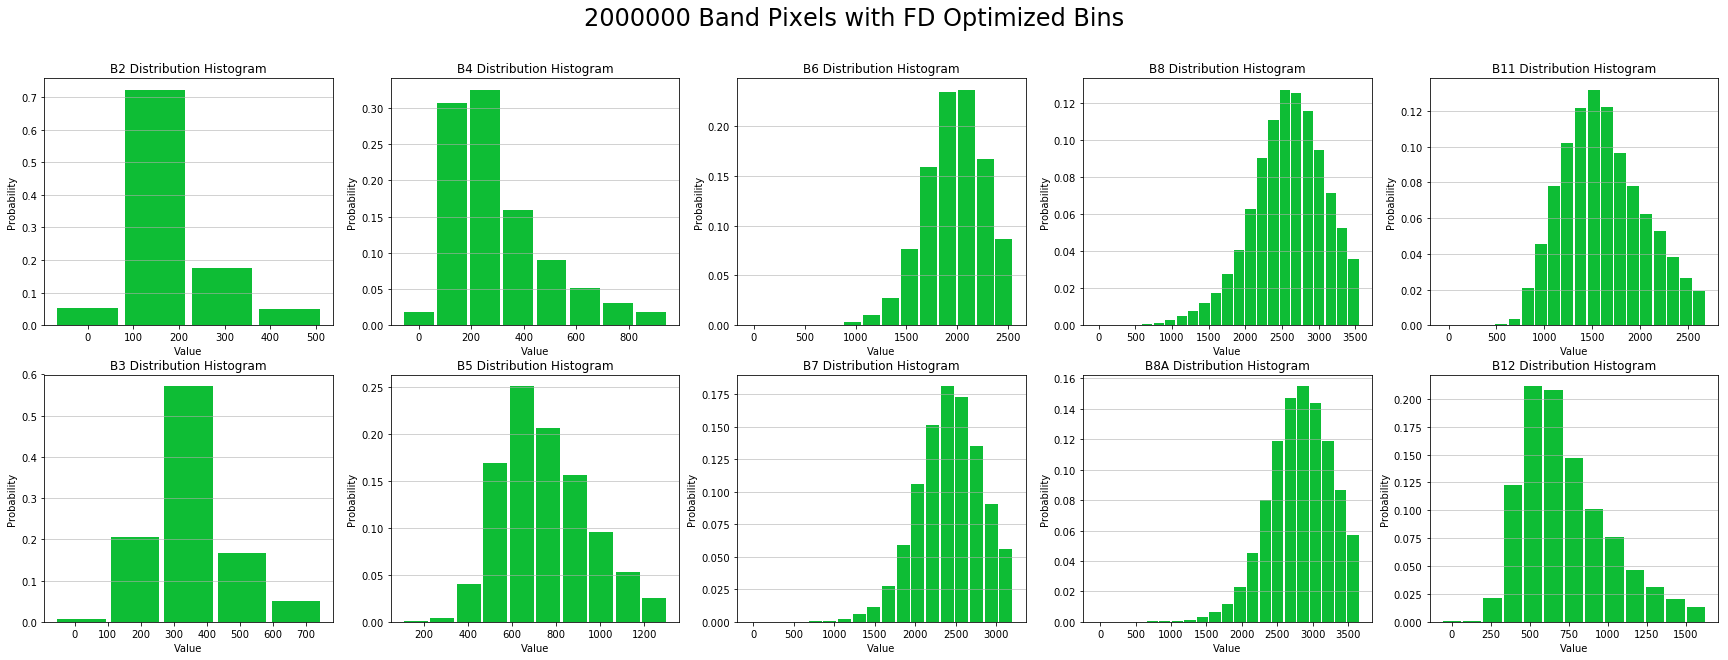

In [46]:
for ess in essstats.ess.unique():
    
    fig, axes = plt.subplots(2, 5, figsize=[30, 10])
    c=np.random.rand(3,)
    
    for i, (_, band, _, mn, mx, _, hist, edges, _, _, _, _) in enumerate(essstats[essstats['ess']==ess].values):
        
        ax = axes[i%2][int(i/2)]
        ax.bar(edges[:-1], hist, width=0.9*(edges[1]-edges[0]), color=c)

        ax.set_title(band + ' Distribution Histogram')
        ax.set_xlabel('Value')
        ax.set_ylabel('Probability')
        ax.grid(axis='y', alpha=0.7)
    
    fig.suptitle(ess+' Band Pixels with FD Optimized Bins', fontsize=24)
    
    plt.savefig(join(path['hist'], ess+'_hist_fd.png'), bbox_inches='tight', dpi=256)
    plt.show()

### ESS Band Pixels with Global Bins

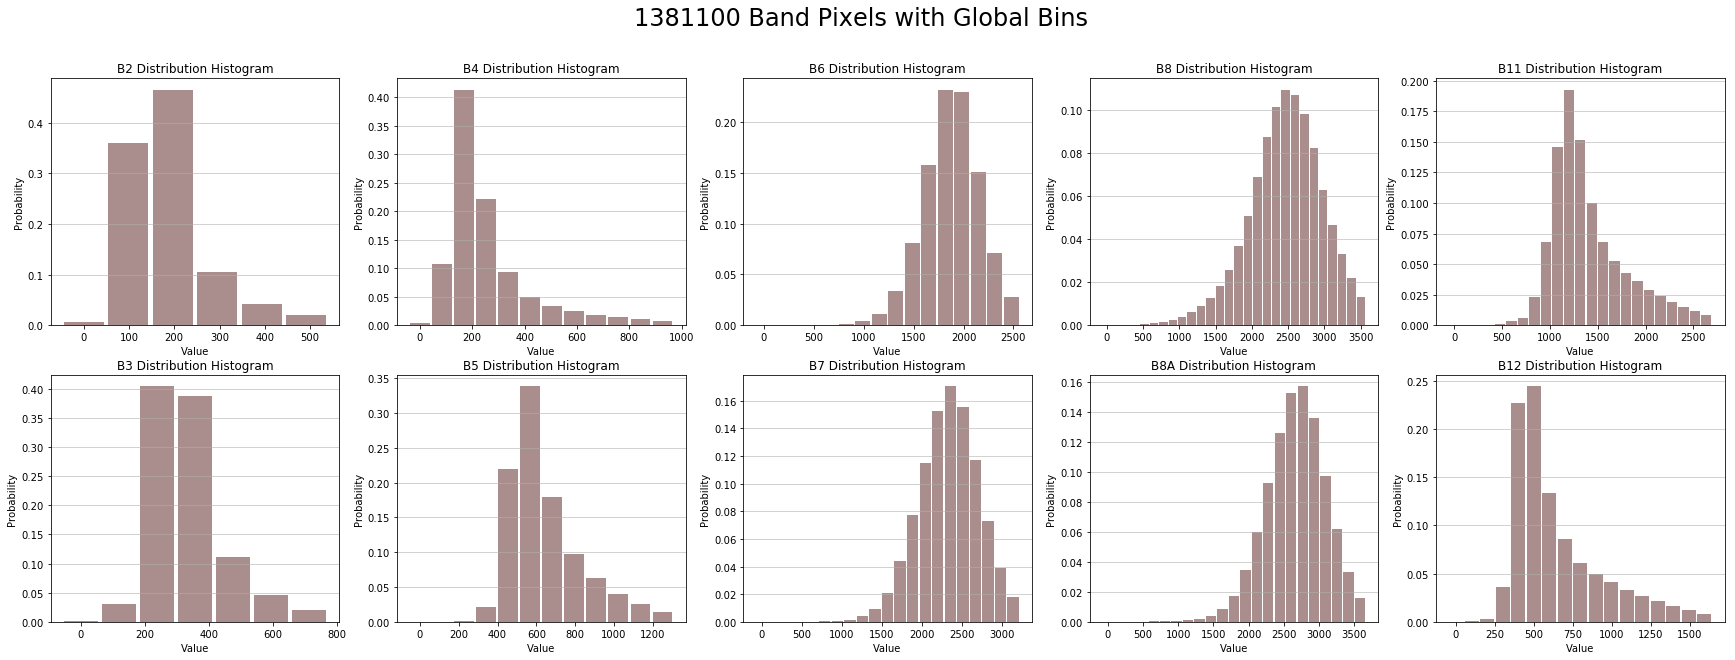

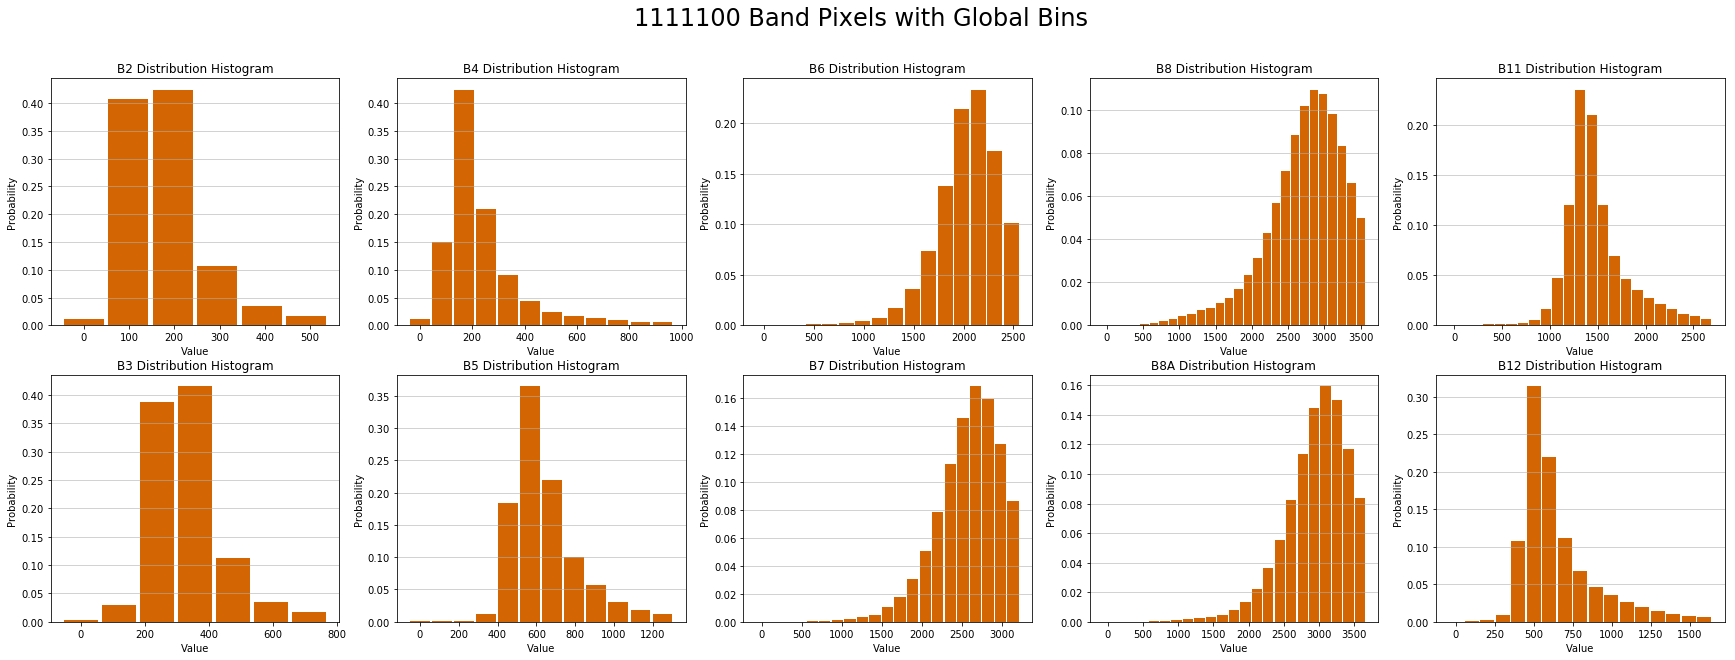

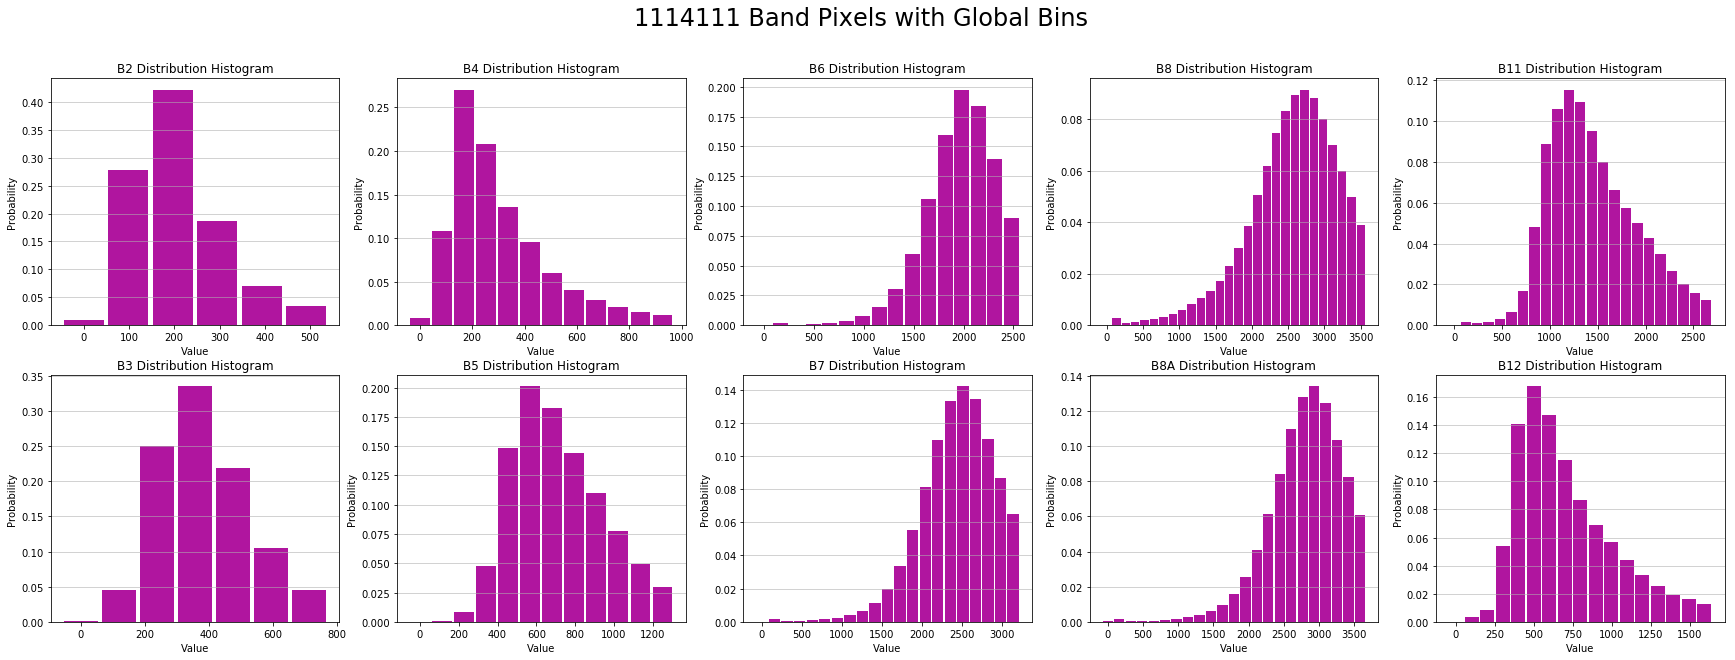

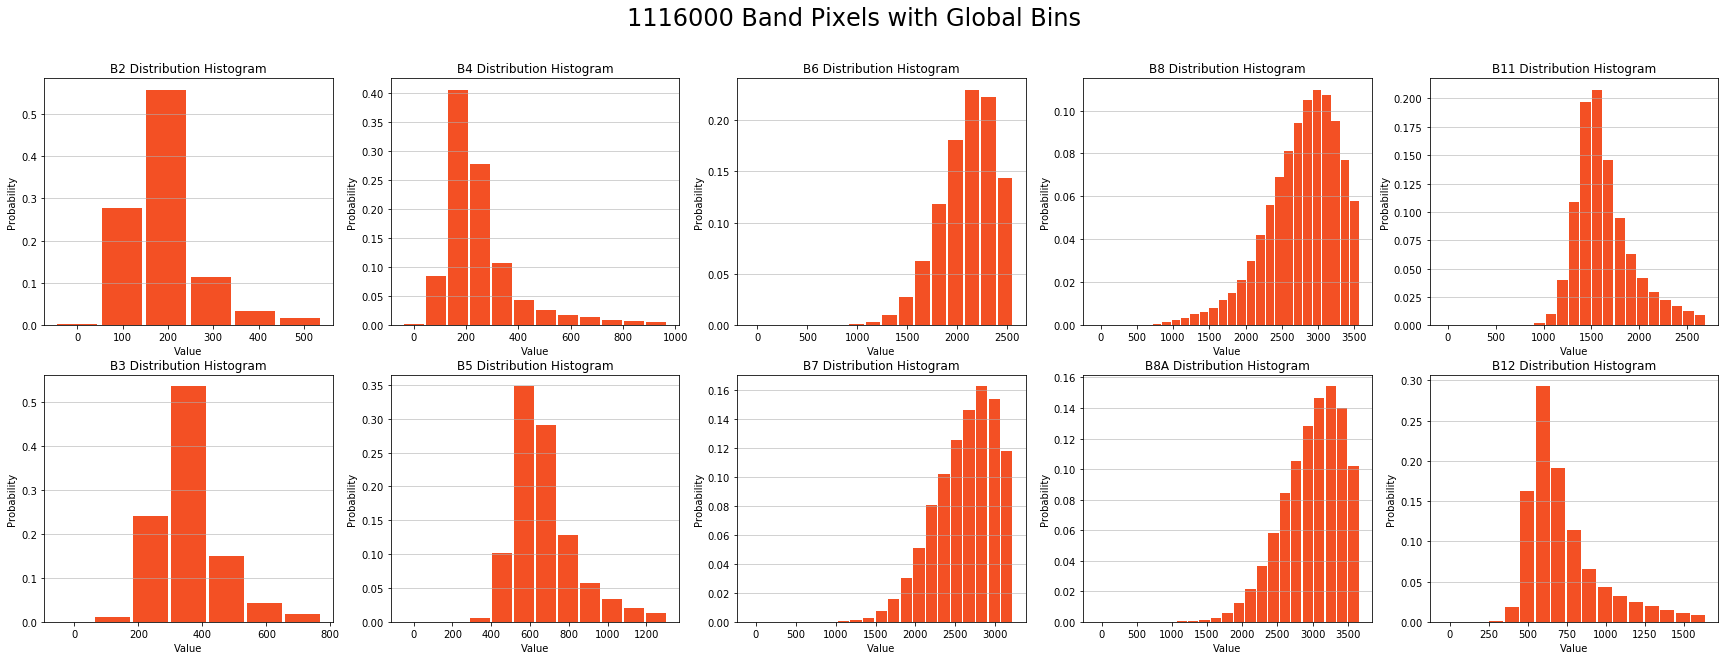

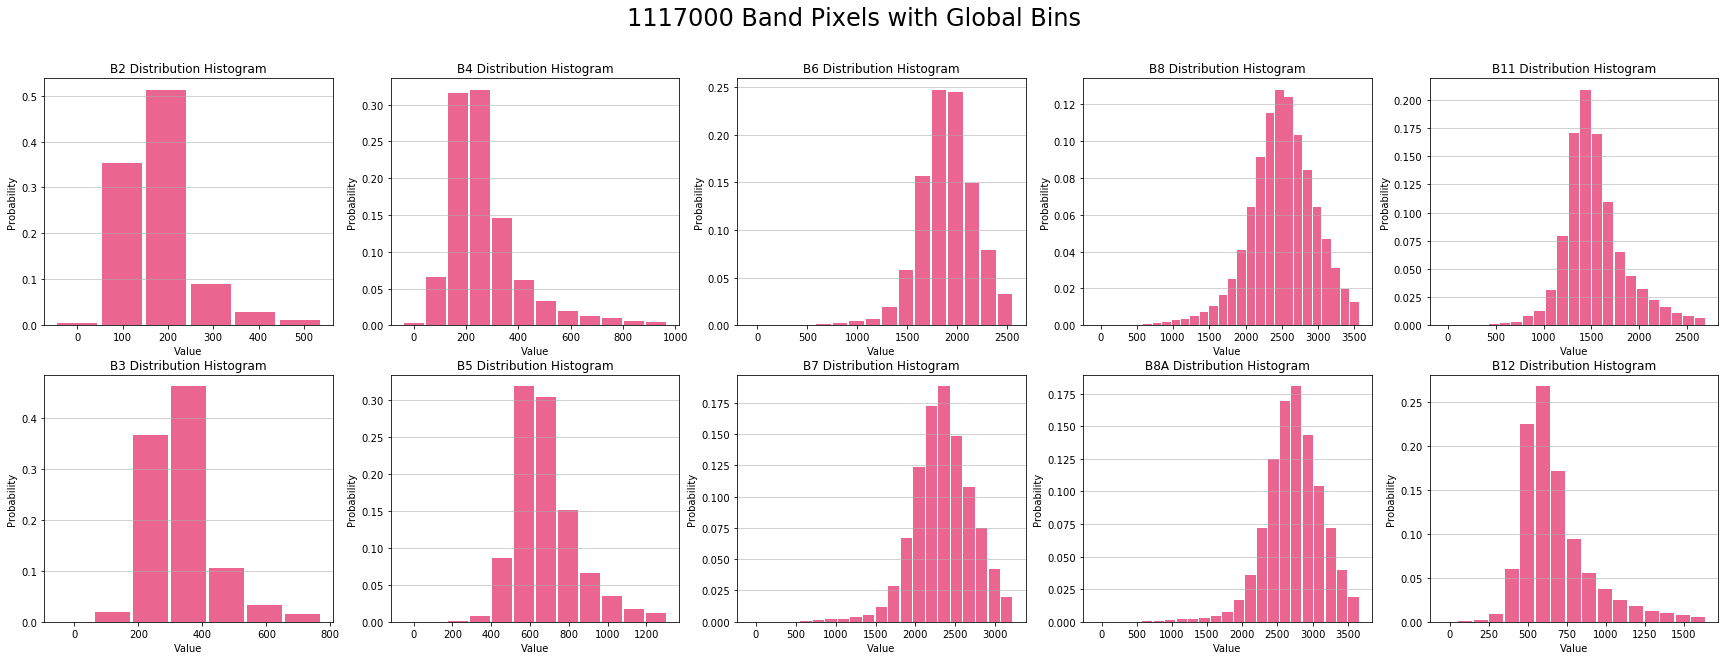

In [47]:
for ess in essstats.ess.unique():
    
    fig, axes = plt.subplots(2, 5, figsize=[30, 10])
    c=np.random.rand(3,)
    
    for i, (_, band, _, mn, mx, _, _, _, _, hist, edges, _) in enumerate(essstats[essstats['ess']==ess].values):
        
        ax = axes[i%2][int(i/2)]
        ax.bar(edges[:-1], hist, width=0.9*(edges[1]-edges[0]), color=c)

        ax.set_title(band + ' Distribution Histogram')
        ax.set_xlabel('Value')
        ax.set_ylabel('Probability')
        ax.grid(axis='y', alpha=0.7)
    
    fig.suptitle(ess+' Band Pixels with Global Bins', fontsize=24)
    
    plt.savefig(join(path['hist'], ess+'_hist.png'), bbox_inches='tight', dpi=256)
    plt.show()

### Merged ESS Band Pixels with Global Bins

In [48]:
def bar_plot(ax, x_values, y_values, labels, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.
    
    y_values: data to plot
    
    labels: names of the data
    
    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    data = dict(zip(labels, y_values))
    
    """
    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width * single_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        #for x, y in enumerate(values):
        for x, y in zip(x_values, values):
            bar = ax.bar(x + x_offset, y, width=bar_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

In [49]:
filter_ess = lambda ess: essstats['ess']==ess
filter_band = lambda band: essstats['band']==band

In [50]:
fig, axes = plt.subplots(2, 5, figsize=[40, 10])

for i, (band, edges, mx) in enumerate(list(zip(bandstats['band'], bandstats['edges'], bandstats['max']))):
    
    labels, hists = zip(*[[ess, essstats[filter_ess(ess) & filter_band(band)]['hist'].values[0]]
                         for ess in essstats.ess.unique()])
    diff = edges[1]-edges[0]
    
    ax = axes[i%2][int(i/2)]
    bar_plot(ax, edges[:-1], hists, labels, single_width=diff)
    
    ax.set_xticks(edges[:-1:2])
    ax.set_xlim(edges[0] - diff*0.6, edges[-2] + diff*0.6)
    
    ax.set_title(band + ' Distribution Histogram')
    ax.set_xlabel('Value')
    ax.set_ylabel('Probability')
    ax.grid(axis='y', alpha=0.7)
    
fig.suptitle('Merged ESS Band Pixels with Global Bins', fontsize=24)

plt.savefig(join(path['hist'], 'class_merged_hist.png'), bbox_inches='tight', dpi=256)
plt.show()

## Compute Shape Histograms

### Get Columns

In [55]:
bandstats.head(1)

band    n_all  max_all        n  min  max  fd  \
0   B2  2135133     6701  2028377    0  589   2   

                                    hist_fd             edges_fd  bins  \
0  [0.7229982394791501, 0.2770017605208499]  [0.0, 294.5, 589.0]     6   

                                                hist  \
0  [0.006000856842687528, 0.26105403482685907, 0....   

                                               edges  \
0  [0.0, 98.16666666666667, 196.33333333333334, 2...   

                                              pixels  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                           edgep    edgep_fd  
0  [98, 196, 294, 392, 490, 589]  [294, 589]

In [ ]:
printable_edges = lambda es: list(map(lambda e: int(e), es[1:]))

In [ ]:
edge_labels = lambda be: [be[0]+'_'+str(e) for e in be[1]]

In [56]:
def column_names(edgep):
    colnames = flatten(map(edge_labels, zip(bandstats['band'], bandstats[edgep])))
    colnames += glcmFeatures
    colnames.append('ess')
    return colnames

### Get Features

In [ ]:
def get_mask_hists(ess, bands, bandedges, glcms):
    hists = flatten([hist_stats(bandpixels, bandedges[band])[0]
                   for band, bandpixels in zip(bands.index, bands.values)])
    
    return hists + list(glcms) + [ess]

In [62]:
def get_mask_features(bandedges):
    return [get_mask_hists(row['CODE_ess'], row[bandOrder], bandedges, row[glcmFeatures]) 
            for num, row in chosenshapes.iterrows()]

### Create DataFrames

In [54]:
bandstats['edgep'] = list(map(printable_edges, bandstats['edges'].values))
bandedges = {b: e for b, e in zip(bandstats['band'], bandstats['edges'])}

shpdf = pd.DataFrame(get_mask_features(bandedges), columns=column_names('edgep'))
shpdf

In [64]:
bandstats['edgep_fd'] = list(map(printable_edges, bandstats['edges_fd'].values))
bandedges_fd = {b: e for b, e in zip(bandstats['band'], bandstats['edges_fd'])}

shpdf_fd = pd.DataFrame(get_mask_features(bandedges_fd), columns=column_names('edgep_fd'))
shpdf_fd

B2_294    B2_589    B3_277    B3_554    B3_832    B4_252    B4_505  \
0     0.700000  0.300000  0.000000  0.700000  0.300000  0.000000  0.500000   
1     0.333333  0.666667  0.000000  0.600000  0.400000  0.000000  0.266667   
2     0.937500  0.062500  0.000000  1.000000  0.000000  0.343750  0.562500   
3     0.936170  0.063830  0.042553  0.914894  0.042553  0.833333  0.125000   
4     0.000000  1.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
8409  0.978992  0.021008  0.011029  0.980042  0.008929  0.069255  0.911857   
8410  0.865705  0.134295  0.033575  0.892015  0.074410  0.276902  0.595678   
8411  0.930477  0.069523  0.062965  0.917796  0.019239  0.507652  0.428946   
8412  0.968330  0.031670  0.028200  0.953579  0.018221  0.331020  0.640781   
8413  0.929137  0.070863  0.207716  0.744769  0.047515  0.781277  0.151855   

        B4_758   B4_1011  B5_227  ...    GLCM_4      GLCM_5        GLCM_6  \
0     0.300000  0.200000     0.0  ...  0.138711  201.794643  15212.376949   
1     0.666667  0.066667     0.0  ...  0.027327  306.141667   2364.766076   
2     0.093750  0.000000     0.0  ...  0.456334   97.899242   9087.036320   
3     0.020833  0.020833     0.0  ...  0.297148  133.033654   9217.531709   
4     0.000000  1.000000     0.0  ...  0.531412  209.645208  52232.736311   
...        ...       ...     ...  ...       ...         ...           ...   
8409  0.015740  0.003148     0.0  ...  0.654893   82.474045  11523.244950   
8410  0.096353  0.031067     0.0  ...  0.596759   93.637626  13077.752941   
8411  0.049847  0.013555     0.0  ...  0.544724   98.350059  10789.886408   
8412  0.022993  0.005206     0.0  ...  0.681414   72.309519   9326.782188   
8413  0.041631  0.025237     0.0  ...  0.486563  106.708260  11255.582820   

        GLCM_7    GLCM_8    GLCM_9   GLCM_10   GLCM_11   GLCM_12      ess  
0     2.848894  3.729846  0.000794  2.723894 -0.842981  0.997459  4000000  
1     3.185056  4.226723  0.000736  2.876723 -0.866678  0.999200  4000000  
2     3.737096  4.389792  0.001226  3.545593 -0.572917  0.981709  4000000  
3     4.620012  5.507306  0.000366  4.286704 -0.686930  0.998279  4000000  
4     3.970768  4.514287  0.000808  3.656746 -0.631787  0.991540  4000000  
...        ...       ...       ...       ...       ...       ...      ...  
8409  3.644060  4.958689  0.001063  2.846231 -0.377415  0.948375  1117000  
8410  4.321434  5.863841  0.000948  3.500465 -0.405854  0.974131  1117000  
8411  4.763032  6.522791  0.001225  3.609908 -0.380285  0.976036  1117000  
8412  3.450481  4.741894  0.001922  2.675368 -0.399097  0.951266  1117000  
8413  5.288377  7.414040  0.000595  3.888300 -0.378368  0.983787  1117000  

[8414 rows x 88 columns]

In [67]:
# Shapes with null values, indicating an issue with feature extraction
len(shpdf[shpdf.isnull().any(axis=1)]), len(shpdf_fd[shpdf_fd.isnull().any(axis=1)])

(0, 0)

In [ ]:
# This will remove the rows above i.e. removing some samples
shpdf = shpdf[shpdf.notnull().all(axis=1)]

# Return the values to list
mask_histograms = shpdf.values.tolist()

## Export Data

In [68]:
shpdf.to_hdf(join(path['data'], 'data.h5'), key='shpdf', mode='w')
shpdf_fd.to_hdf(join(path['data'], 'data_fd.h5'), key='shpdf', mode='w')